# Dependencies

In [6]:
import qutip as qp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from Hamiltonian import *

# Hamiltonian

The Hamiltonian describing the collective oscillation of 2-flavored neutrinos in the flavor basis is:
$$
H = \sum_{i} \frac{\delta m^2}{4E}(\sin 2\theta X_i - \cos 2\theta Z_i) + \frac{G_F N_e}{\sqrt 2 V}Z_i + \sum_{j, k} \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij}) (X_j X_k + Y_jY_k + Z_jZ_k)
$$
where $V$ is the volume of the system, $N_e$ is the number of background electrons, $\theta$ the mixing angle and $\phi_{ij}$ the propagation angle between neutrino $i$ and $j$
This Hamiltonian can be rewritten in terms of pairs of neutrinos. Suppose there are $N$ neutrinos indexed $0$ to $N-1$, then the set of all pairs is $P = \{(i,j)|0 \le i < j\le N-1 \}$. The Hamiltonian is then
$$
H = \sum_{(i,j)\in P} \frac{\delta m^2}{4E(N-1)}(\sin 2\theta X_i - \cos 2\theta Z_i) + \frac{G_F N_e}{\sqrt 2 V}Z_i +  \frac{\delta m^2}{4E(N-1)}(\sin 2\theta X_j - \cos 2\theta Z_j) + \frac{G_F N_e}{\sqrt 2 V}Z_j + \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij}) (X_i X_j + Y_iY_j + Z_iZ_j)
$$

## Explanation

To understand the form of the Hamiltonian we shall start by looking at the Hamiltonian of a single neutrino in a vacuum. This neutrino's mass is an observable with eigenstates $|m_1\rangle, |m_2\rangle$. These mass eigenstates are also the energy eigenstates, which means the Hamiltonian in the mass basis is $\frac{\delta m^2}{4E}Z$ (up to a constant offset).

Just as electrons posses spin, neutrinos posses flavor. The eigenstates of flavor are $|\nu_e\rangle$ and $|\nu_\mu\rangle$ (electron and muon neutrinos). For simulation purposes we will encode them as $|\nu_e\rangle = |0\rangle$ and $|\nu_\mu\rangle = |1\rangle$.

Converting a vector in flavor basis into a vector in mass basis is done by multiplying with the matrix:
$$
\begin{bmatrix}
\cos 2\theta & -\sin 2\theta\\
\sin 2\theta & \cos 2\theta
\end{bmatrix}
$$
$\theta$ is called the mixing angle because it describes how mass and flavor mix.

The vacuum Hamiltonian in flavor basis is hence (up to a global phase)
$$
\frac{\delta m^2}{4E} \begin{bmatrix}
-\cos 2\theta & \sin 2\theta\\
\sin 2\theta & \cos 2\theta
\end{bmatrix} = \frac{\delta m^2}{4E}(\sin 2\theta X - \cos 2\theta Z)
$$

The presence of electrons scatters electron neutrino, thus changing the energy for electron neutrinos. This is reflected in the Hamiltonian by adding $\frac{\sqrt 2 G_F N_e}{ V} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}$. The Hamiltonian of a neutrino in matter is thus $\frac{\delta m^2}{4E}(\sin 2\theta X - \cos 2\theta Z) + \frac{G_F N_e}{\sqrt 2 V}Z$, once again up to a constant.

Now for a pair of neutrinos, we will describe their interaction/scattering similar to the Heisenberg model, as $J(X_1X_2+Y_1Y_2+Z_1Z_2)$. The strength of interaction, $J$, should be propotional to the cosine/angular distance between the momenta of the neutrinos. Indeed, $J = \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij})$ where $\phi$, the propagation angle, is the angle between the momentum vectors of the two neutrinos.

And so the Hamiltonian for $N$ neutrinos is the sum Hamiltonian for each neutrino plus the interaction between every pair.

## Initial Conditions

In [8]:
N = 4
theta = 0.195
phi = np.array([ [np.arccos(0.9) * np.abs(i-j)/(N-1) for j in range(N)] for i in range(N)])
delta = 1e-4
E = 1e-4
Gf, _, _ = sp.constants.physical_constants['Fermi coupling constant']
V = np.sqrt(2)*4*Gf
Ne = 2
initial_flavors = np.array([0,0,1,1])
print(initial_flavors)

t_start = 0 
t_end = 10
steps = 500

[0 0 1 1]


### Reference Hamiltonian

Check if implementation matches the result from Trapped-Ion Quantum Simulation of Collective Neutrino Oscillations

In [14]:
def ReferenceHamiltonian(N):
    """https://arxiv.org/pdf/2102.12556.pdf"""
    H = qp.tensor([0 * qp.identity(2) for i in range(N)])
    for i in range(N):
        H += np.sqrt(1-0.925**2) * pauliX(i,N) - 0.925 * pauliZ(i,N)
    for i in range(N):
        for j in range(N):
            if i < j:
                angle = np.arccos(0.9) * np.abs(j-i)/(N-1)
                J = 1 - np.cos(angle)
                H += J * (pauliX(i,N) * pauliX(j,N) + pauliY(i,N) * pauliY(j,N) + pauliZ(i,N) * pauliZ(j,N))
    return H

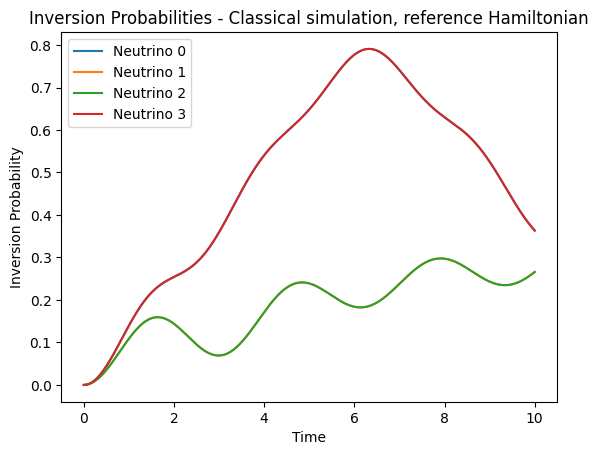

In [15]:
H = ReferenceHamiltonian(N)
times = np.linspace(t_start, t_end, num=steps)
initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
result = qp.mesolve(H, initial_state, times, [])
density_matrices = [qp.ket2dm(state) for state in result.states]
probabilities = np.zeros((N,steps))
for t_idx, dm in enumerate(density_matrices):
    for i in range(N):
        probabilities[i, t_idx] = dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0]
        
# Plot the probability curve for each qubit on the same graph
for qubit in range(N):
    plt.plot(times, probabilities[qubit], label=f'Neutrino {qubit}')

plt.xlabel('Time')
plt.ylabel('Inversion Probability')
plt.title('Inversion Probabilities - Classical simulation, reference Hamiltonian')
plt.legend()
plt.show()

### Dynamics from initial condition

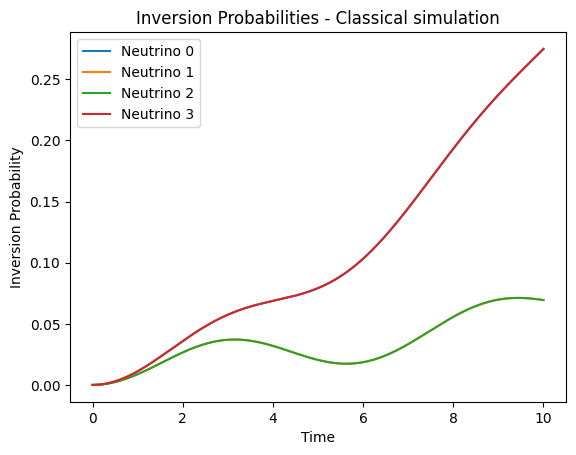

In [11]:
H = Hamiltonian(N, theta, phi, delta, E, V, Ne)
times = np.linspace(t_start, t_end, num=steps)
initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
result = qp.mesolve(H, initial_state, times, [])
density_matrices = [qp.ket2dm(state) for state in result.states]
probabilities = np.zeros((N,steps))
for t_idx, dm in enumerate(density_matrices):
    for i in range(N):
        probabilities[i, t_idx] = dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0]
        
# Plot the probability curve for each qubit on the same graph
for qubit in range(N):
    plt.plot(times, probabilities[qubit], label=f'Neutrino {qubit}')

plt.xlabel('Time')
plt.ylabel('Inversion Probability')
plt.title('Inversion Probabilities - Classical simulation')
plt.legend()
plt.show()